In [ ]:
from platform import python_version
print(python_version())

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import itertools
import json
import sys
sys.path.append("..")
from utils import data_proc_tools as dpt
from utils import plot_tools as pt
from utils.custom_metrics import recall, precision, binary_accuracy
from utils.custom_metrics import recall_np, precision_np, binary_accuracy_np, multilabel_confusion_matrix
from utils.multi_label_text_models import MultiLabelMultiOutputTextCNN
import random
random.seed(42)
random_state=1000
import pylab
pd.set_option('display.max_colwidth', -1)

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

Using TensorFlow backend.


In [3]:
dir = '/vol/medic02/users/ag6516/image_sentence_mapping/'
data_dir = dir + 'data/chestx/'
data_type = 'processed_balanced'
data_output_dir = dir + 'data/chestx/{}/'.format(data_type)
dicts_dir = dir + 'data/chestx/{}/dicts/'.format(data_type)

In [4]:
PATHOLOGY_VOCAB_LEN = 41
ANATOMY_VOCAB_LEN = 27
POSITION_VOCAB_LEN = 6
SEVERITY_VOCAB_LEN = 28

### Load samples, vectorise text reports and mesh captions

In [5]:
sample_size = 100

In [6]:
val_df = pd.read_pickle(data_output_dir + 'val/val_300.pkl')
train_df = pd.read_pickle(data_output_dir + 'train_{0}/train_{0}.pkl'.format(sample_size))

In [7]:
len(train_df)

100

In [8]:
# initialise vectoriser. if id dictionaries exist, set load_dicts=True
train_vectoriser = dpt.Vectoriser(data_output_dir+'train_{}/'.format(sample_size), load_dicts=True, dicts_dir=dicts_dir)
val_vectoriser = dpt.Vectoriser(data_output_dir+'val/', load_dicts=True, dicts_dir=dicts_dir)

In [9]:
# extract tokenized sentences and entities from df
train_tok_reports_padded = list(train_df.tok_reports_padded)
train_mesh_captions = list(train_df.reduced_single_mesh)

val_tok_reports_padded = list(val_df.tok_reports_padded)
val_mesh_captions = list(val_df.reduced_single_mesh)

In [10]:
# vectorize mesh captions
train_vectoriser.entities_to_vectors(train_mesh_captions, save=True)
val_vectoriser.entities_to_vectors(val_mesh_captions, save=True)

# vectorise reports
train_vectoriser.sentences_to_vectors(train_tok_reports_padded)
val_vectoriser.sentences_to_vectors(val_tok_reports_padded)

Creating list of word ids from loaded dictionaries
Creating list of word ids from loaded dictionaries


In [11]:
# get token_ids_array and one-hot-encode mesh captions
train_token_ids_array = train_vectoriser.token_ids_array
train_mesh_ids_array = train_vectoriser.ents_ids_array

val_token_ids_array = val_vectoriser.token_ids_array
val_mesh_ids_array = val_vectoriser.ents_ids_array

word_to_id = train_vectoriser.word_to_id
id_to_word = train_vectoriser.id_to_word

mesh_to_id = train_vectoriser.ent_to_id
id_to_mesh = train_vectoriser.id_to_ent

train_mesh_vectors = dpt.one_hot_encode(train_mesh_ids_array, len(mesh_to_id))
val_mesh_vectors = dpt.one_hot_encode(val_mesh_ids_array, len(mesh_to_id))

In [12]:
reports_train = train_token_ids_array
mesh_train = train_mesh_vectors

reports_val = val_token_ids_array
mesh_val = val_mesh_vectors

In [13]:
train_mesh_vectors.shape

(100, 102)

### Stats on classes

In [14]:
# number of instances per class
print('Number of instances per class in training sample:')
print(mesh_train.sum(axis=0))
print('')
print('Average number of instances per class: {}'.format(mesh_train.sum(axis=0).mean()))
print('')
print('Average number of class instances per sample: {}'.format(mesh_train.sum(axis=1).mean()))

Number of instances per class in training sample:
[ 8.  8.  3.  7.  4.  3. 11.  1.  1.  1.  5.  1.  2.  1.  1.  1.  2.  1.
  2.  1.  1.  1.  1.  3.  1.  1.  1.  1.  1.  2.  1.  1.  1.  2.  2.  1.
  3.  1.  1.  1.  1.  2.  6.  4.  1.  0.  1.  0.  0.  0.  0.  5.  2.  6.
  0. 27.  6.  3.  0.  1.  0.  4.  0.  3.  1.  5.  0.  2.  0.  8. 11. 12.
  3. 22.  0.  1.  2.  4.  1.  0.  0.  0.  1.  1.  1.  0.  1.  0.  1.  1.
 12.  2.  8.  4.  0.  0.  1.  0.  1.  3.  1.  1.]

Average number of instances per class: 2.686274528503418

Average number of class instances per sample: 2.740000009536743


In [15]:
# number of instances per class
print('Number of instances per class in val sample:')
print(mesh_val.sum(axis=0))
print('')
print('Average number of instances per class: {}'.format(mesh_val.sum(axis=0).mean()))
print('')
print('Average number of class instances per sample: {}'.format(mesh_val.sum(axis=1).mean()))

Number of instances per class in val sample:
[ 33.  51.  15.  21.   6.   1.  16.   2.   1.   1.  16.   6.   5.   5.
   1.   3.   6.   4.   5.   3.   2.   3.   1.   7.   2.   1.   2.  12.
   1.   8.   5.   2.   2.   7.   2.   1.   1.   7.   1.   1.   1.   4.
  13.  11.   0.   0.   3.   2.   1.   1.   2.  16.   4.  19.   1. 108.
  11.  11.   1.   3.   4.   5.   0.   8.   1.  15.   2.  10.   5.  34.
  35.  41.   2.  58.   0.   5.   7.  11.   3.   2.   3.   0.   2.   1.
   3.   6.  12.   1.   0.   0.  47.   2.  18.   9.   7.   2.   6.   2.
   1.   6.   6.   7.]

Average number of instances per class: 8.529411315917969

Average number of class instances per sample: 2.9000000953674316


## Train Text CNN Model

In [47]:
input_dim = train_vectoriser.vocab_len
max_sentence_length = train_vectoriser.max_sen_len
#output_dim = mesh_train.shape[1]
dense_output_dims = [PATHOLOGY_VOCAB_LEN, ANATOMY_VOCAB_LEN, POSITION_VOCAB_LEN, SEVERITY_VOCAB_LEN]
loss_weights = {'pathology': 0.4, 'anatomy': 0.2, 'position': 0.2, 'severity': 0.2}
output_dim = [256, 256, 256, 256]
epochs = 100
optimizer = 'adam'
batch_size = 128
embedding_dim = 512
conv_dim1 = 512
conv_dim2 = 64
fc_dim = 2048

new_experiment = MultiLabelMultiOutputTextCNN(
                               dense_output_dims=dense_output_dims,
                               loss_weights=loss_weights,
                               epochs=epochs,
                               #metrics=['acc', binary_accuracy,recall,precision],
                               optimizer=optimizer,
                               batch_size=batch_size, 
                               embedding_dim=embedding_dim, 
                               fc_dim=fc_dim,
                               conv_dim1=conv_dim1, 
                               conv_dim2=conv_dim2, 
                               input_dim=input_dim, 
                               max_sentence_length=max_sentence_length, 
                               output_dim=output_dim, 
                               verbose=True)
new_experiment.build_model()
new_experiment.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 32, 512)      518144      input_25[0][0]                   
__________________________________________________________________________________________________
conv1d_38 (Conv1D)              (None, 30, 512)      786944      embedding_25[0][0]               
__________________________________________________________________________________________________
max_pooling1d_21 (MaxPooling1D) (None, 10, 512)      0           conv1d_38[0][0]                  
__________________________________________________________________________________________________
global_max

In [14]:
split_mesh_train = [mesh_train[:, 0:PATHOLOGY_VOCAB_LEN], 
                    mesh_train[:, PATHOLOGY_VOCAB_LEN:PATHOLOGY_VOCAB_LEN+ANATOMY_VOCAB_LEN],
                    mesh_train[:, PATHOLOGY_VOCAB_LEN+ANATOMY_VOCAB_LEN:PATHOLOGY_VOCAB_LEN+ANATOMY_VOCAB_LEN+POSITION_VOCAB_LEN],
                    mesh_train[:, PATHOLOGY_VOCAB_LEN+ANATOMY_VOCAB_LEN+POSITION_VOCAB_LEN:]]

split_mesh_val = [mesh_val[:, 0:PATHOLOGY_VOCAB_LEN], 
                  mesh_val[:, PATHOLOGY_VOCAB_LEN:PATHOLOGY_VOCAB_LEN+ANATOMY_VOCAB_LEN],
                  mesh_val[:, PATHOLOGY_VOCAB_LEN+ANATOMY_VOCAB_LEN:PATHOLOGY_VOCAB_LEN+ANATOMY_VOCAB_LEN+POSITION_VOCAB_LEN],
                  mesh_val[:, PATHOLOGY_VOCAB_LEN+ANATOMY_VOCAB_LEN+POSITION_VOCAB_LEN:]]

In [ ]:
new_experiment.run_experiment(reports_train, split_mesh_train, reports_val, split_mesh_val)

Train on 100 samples, validate on 300 samples
Epoch 1/100


In [ ]:
model_output_dir = dir + 'trained_models/chestx/text_cnn/train_{}/{}/'.format(sample_size, data_type)
new_experiment.save_weights_history(model_output_dir)

In [16]:
combined_mesh_train = np.concatenate(split_mesh_val, axis=1)
combined_mesh_train.shape

(300, 102)

### Load results of specific experiment

In [ ]:
sample_size = 100
model_output_dir = dir + 'trained_models/chestx/text_cnn_multi_output/train_{}/'.format(sample_size)

In [ ]:
epochs = 100
conv_dim = 512
embedding_dim = 512
loss_name = 'categorical_crossentropy'
loss_weights = {'pathology': 0.25, 'anatomy': 0.25, 'position': 0.25, 'severity': 0.25}

param_fn = 'param_cnn_{}_epochs_{}_convdim_{}_embeddingdim_{}_loss_weights.json'\
.format(epochs, conv_dim, embedding_dim, [float(x) for x in loss_weights.values()])
params = json.load(open(model_output_dir + param_fn, 'r'))

old_experiment = MultiLabelMultiOutputTextCNN(**params)
old_experiment.build_model()
old_experiment.load_weights_history(model_output_dir)

In [ ]:
_pred_mesh_val = old_experiment.model.predict(reports_val)
_pred_mesh_train = old_experiment.model.predict(reports_train)
pred_mesh_val = np.array([_pred_mesh_val > 0.5])*1.0
pred_mesh_val = pred_mesh_val[0]
pred_mesh_train = np.array([_pred_mesh_train > 0.5])*1.0
pred_mesh_train = pred_mesh_train[0]

In [ ]:
# metrics for all classes

t_loss, t_accuracy = old_experiment.model.evaluate(reports_train, mesh_train, verbose=False)
print("Training Loss: {:.4f}".format(t_loss))
val_loss, val_accuracy = old_experiment.model.evaluate(reports_val, mesh_val, verbose=False)
print("Validation Loss:  {:.4f}\n".format(val_loss))

avg_binary_accuracy = binary_accuracy_np(mesh_train, pred_mesh_train)
print("Training Binary Accuracy: {:.2f}".format(avg_binary_accuracy*100))
avg_binary_accuracy = binary_accuracy_np(mesh_val, pred_mesh_val)
print("Validation Binary Accuracy:  {:.2f}\n".format(avg_binary_accuracy*100))

recall, avg_class, avg_sample = recall_np(mesh_train, pred_mesh_train)
print("Training Recall: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}".format(recall*100,avg_class*100,avg_sample*100))
recall, avg_class, avg_sample = recall_np(mesh_val, pred_mesh_val)
print("Validation Recall: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}\n".format(recall*100,avg_class*100,avg_sample*100))

precision, avg_class, avg_sample = precision_np(mesh_train, pred_mesh_train)
print("Training Precision: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}".format(precision*100,avg_class*100,avg_sample*100))
precision, avg_class, avg_sample = precision_np(mesh_val, pred_mesh_val)
print("Validation Precision: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}\n".format(precision*100,avg_class*100,avg_sample*100))

In [ ]:
# metrics for pathologies only
mesh_train_p = mesh_train[:,0:len(pathology)]
pred_mesh_train_p = pred_mesh_train[:,0:len(pathology)]
mesh_val_p = mesh_val[:,0:len(pathology)]
pred_mesh_val_p = pred_mesh_val[:,0:len(pathology)]

avg_binary_accuracy = binary_accuracy_np(mesh_train_p, pred_mesh_train_p)
print("Training Binary Accuracy: {:.2f}".format(avg_binary_accuracy*100))
avg_binary_accuracy = binary_accuracy_np(mesh_val_p, pred_mesh_val_p)
print("Validation Binary Accuracy:  {:.2f}\n".format(avg_binary_accuracy*100))

recall, avg_class, avg_sample = recall_np(mesh_train_p, pred_mesh_train_p)
print("Training Recall: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}".format(recall*100,avg_class*100,avg_sample*100))
recall, avg_class, avg_sample = recall_np(mesh_val_p, pred_mesh_val_p)
print("Validation Recall: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}\n".format(recall*100,avg_class*100,avg_sample*100))

precision, avg_class, avg_sample = precision_np(mesh_train_p, pred_mesh_train_p)
print("Training Precision: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}".format(precision*100,avg_class*100,avg_sample*100))
precision, avg_class, avg_sample = precision_np(mesh_val_p, pred_mesh_val_p)
print("Validation Precision: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}\n".format(precision*100,avg_class*100,avg_sample*100))

In [ ]:
# metrics for anatomy only
mesh_train_p = mesh_train[:,len(pathology):len(pathology)+len(anatomy)]
pred_mesh_train_p = pred_mesh_train[:,len(pathology):len(pathology)+len(anatomy)]
mesh_val_p = mesh_val[:,len(pathology):len(pathology)+len(anatomy)]
pred_mesh_val_p = pred_mesh_val[:,len(pathology):len(pathology)+len(anatomy)]

avg_binary_accuracy = binary_accuracy_np(mesh_train_p, pred_mesh_train_p)
print("Training Binary Accuracy: {:.2f}".format(avg_binary_accuracy*100))
avg_binary_accuracy = binary_accuracy_np(mesh_val_p, pred_mesh_val_p)
print("Validation Binary Accuracy:  {:.2f}\n".format(avg_binary_accuracy*100))

recall, avg_class, avg_sample = recall_np(mesh_train_p, pred_mesh_train_p)
print("Training Recall: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}".format(recall*100,avg_class*100,avg_sample*100))
recall, avg_class, avg_sample = recall_np(mesh_val_p, pred_mesh_val_p)
print("Validation Recall: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}\n".format(recall*100,avg_class*100,avg_sample*100))

precision, avg_class, avg_sample = precision_np(mesh_train_p, pred_mesh_train_p)
print("Training Precision: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}".format(precision*100,avg_class*100,avg_sample*100))
precision, avg_class, avg_sample = precision_np(mesh_val_p, pred_mesh_val_p)
print("Validation Precision: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}\n".format(precision*100,avg_class*100,avg_sample*100))

In [ ]:
# metrics for position only
mesh_train_p = mesh_train[:,len(pathology)+len(anatomy):len(pathology)+len(anatomy)+len(position)]
pred_mesh_train_p = pred_mesh_train[:,len(pathology)+len(anatomy):len(pathology)+len(anatomy)+len(position)]
mesh_val_p = mesh_val[:,len(pathology)+len(anatomy):len(pathology)+len(anatomy)+len(position)]
pred_mesh_val_p = pred_mesh_val[:,len(pathology)+len(anatomy):len(pathology)+len(anatomy)+len(position)]

avg_binary_accuracy = binary_accuracy_np(mesh_train_p, pred_mesh_train_p)
print("Training Binary Accuracy: {:.2f}".format(avg_binary_accuracy*100))
avg_binary_accuracy = binary_accuracy_np(mesh_val_p, pred_mesh_val_p)
print("Validation Binary Accuracy:  {:.2f}\n".format(avg_binary_accuracy*100))

recall, avg_class, avg_sample = recall_np(mesh_train_p, pred_mesh_train_p)
print("Training Recall: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}".format(recall*100,avg_class*100,avg_sample*100))
recall, avg_class, avg_sample = recall_np(mesh_val_p, pred_mesh_val_p)
print("Validation Recall: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}\n".format(recall*100,avg_class*100,avg_sample*100))

precision, avg_class, avg_sample = precision_np(mesh_train_p, pred_mesh_train_p)
print("Training Precision: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}".format(precision*100,avg_class*100,avg_sample*100))
precision, avg_class, avg_sample = precision_np(mesh_val_p, pred_mesh_val_p)
print("Validation Precision: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}\n".format(precision*100,avg_class*100,avg_sample*100))

In [ ]:
# metrics for severity only
mesh_train_p = mesh_train[:,len(pathology)+len(anatomy)+len(position):]
pred_mesh_train_p = pred_mesh_train[:,len(pathology)+len(anatomy)+len(position):]
mesh_val_p = mesh_val[:,len(pathology)+len(anatomy)+len(position):]
pred_mesh_val_p = pred_mesh_val[:,len(pathology)+len(anatomy)+len(position):]

avg_binary_accuracy = binary_accuracy_np(mesh_train_p, pred_mesh_train_p)
print("Training Binary Accuracy: {:.2f}".format(avg_binary_accuracy*100))
avg_binary_accuracy = binary_accuracy_np(mesh_val_p, pred_mesh_val_p)
print("Validation Binary Accuracy:  {:.2f}\n".format(avg_binary_accuracy*100))

recall, avg_class, avg_sample = recall_np(mesh_train_p, pred_mesh_train_p)
print("Training Recall: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}".format(recall*100,avg_class*100,avg_sample*100))
recall, avg_class, avg_sample = recall_np(mesh_val_p, pred_mesh_val_p)
print("Validation Recall: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}\n".format(recall*100,avg_class*100,avg_sample*100))

precision, avg_class, avg_sample = precision_np(mesh_train_p, pred_mesh_train_p)
print("Training Precision: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}".format(precision*100,avg_class*100,avg_sample*100))
precision, avg_class, avg_sample = precision_np(mesh_val_p, pred_mesh_val_p)
print("Validation Precision: {:.2f} Avg. over classes: {:.2f} Avg. over samples: {:.2f}\n".format(precision*100,avg_class*100,avg_sample*100))

In [ ]:
pt.plot_history(old_experiment.history)

### Plot per-class confusion matrices

In [ ]:
matrix_val = multilabel_confusion_matrix(mesh_val, pred_mesh_val)
matrix_train = multilabel_confusion_matrix(mesh_train, pred_mesh_train)
print(len(matrix_train), len(matrix_val))

In [ ]:
import seaborn as sn

fig, axs = plt.subplots(25,4, figsize=(20,90))
#fig.subplots_adjust(hspace=0.01, wspace=0.01)
axs = axs.ravel()
cmap=plt.cm.Blues

for i in range(len(matrix_val)):
    df_cm = pd.DataFrame(matrix_val[i], index = [idx for idx in ['Pred Pos', 'Pred Neg']],
                  columns = [idx for idx in ['True Pos', 'True Neg']])
    sn.heatmap(df_cm, annot=True, ax=axs[i])
    axs[i].set_title(train_vectoriser.id_to_ent[i])

### Predict and sample

In [ ]:
# sample some outputs
zipped_val = list(zip(reports_val, mesh_val, pred_mesh_val))
val_samples = random.sample(zipped_val,5)

In [ ]:
train_vectoriser.sample_output(val_samples)

## Plot convergence of multiple models

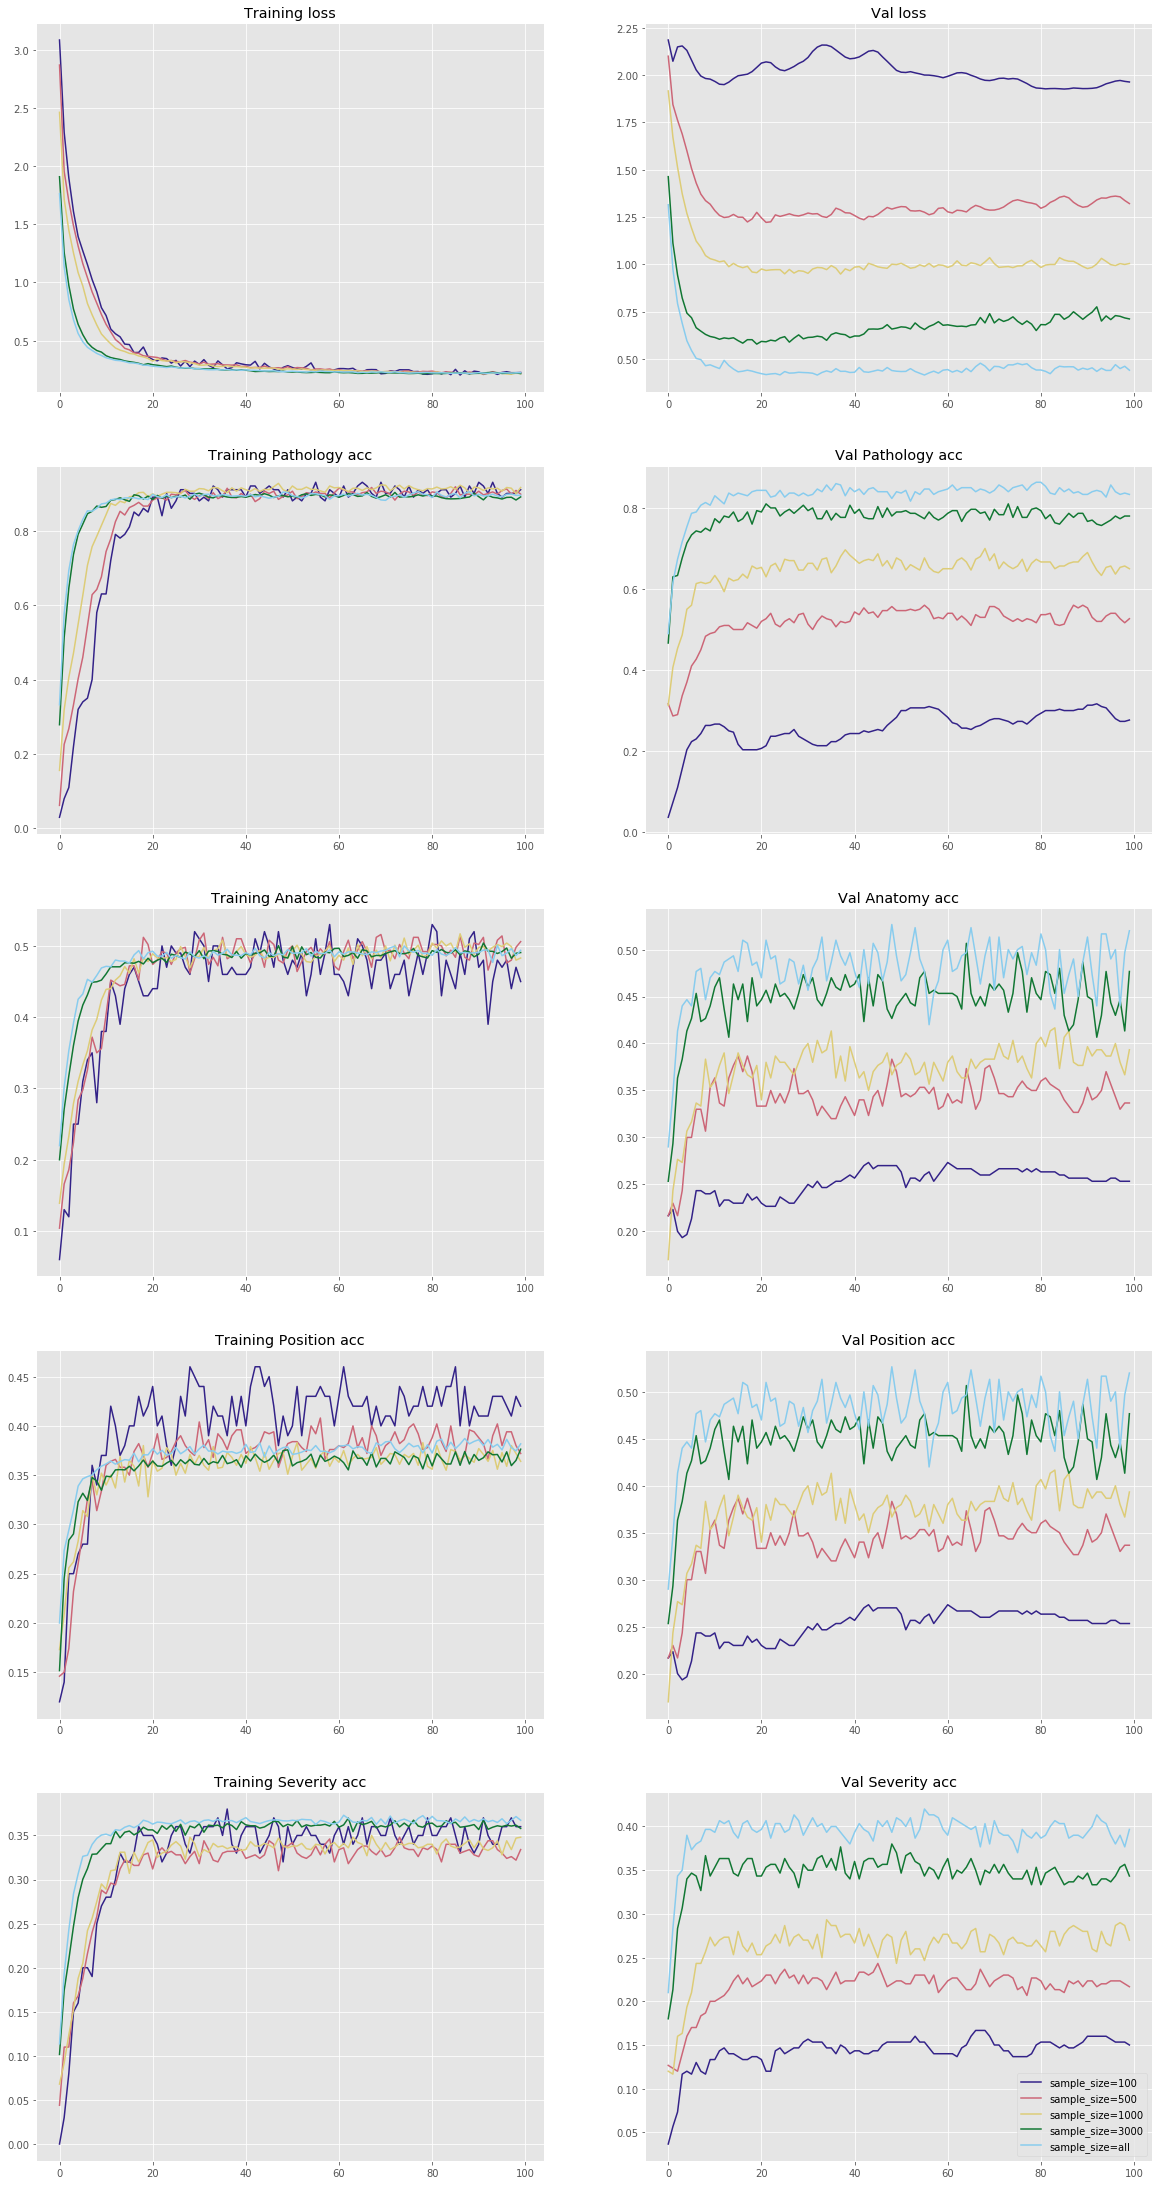

In [22]:
# load and plot history
from cycler import cycler

epochs = 100
conv_dim = 512
embedding_dim = 512
loss_name = 'categorical_crossentropy'
loss_weights = {'pathology': 0.25, 'anatomy': 0.25, 'position': 0.25, 'severity': 0.25}

bce_weights = np.linspace(0.1,1,10)
recall_weights = np.linspace(0.1,1,10)

plt.rc('axes', prop_cycle=(cycler('color', ['#332288', '#CC6677', '#DDCC77', '#117733', '#88CCEE', '#AA4499', 
                     '#44AA99', '#999933', '#882255', '#661100', '#6699CC', '#AA4466'])))
plt.figure(figsize=(20, 80))

for sample_size in [100, 500, 1000, 3000, 'all']:
#     for bce_weight in [1.0]:
#         for recall_weight in recall_weights:
# try:
    model_output_dir = dir + 'trained_models/chestx/text_cnn_multi_output/train_{}/'.format(sample_size)
    history_fn = 'history_cnn_{}_epochs_{}_convdim_{}_embeddingdim_{}_loss_weights.json'\
    .format(epochs, conv_dim, embedding_dim, [float(x) for x in loss_weights.values()])
    history = json.load(open(model_output_dir + history_fn, 'r'))
    label = 'sample_size={}'.format(sample_size)
    
    plt.subplot(10,2,1)
    plt.plot(history['loss'], label=label)
    plt.title('Training loss')
    plt.subplot(10,2,2)
    plt.plot(history['val_loss'], label=label)
    plt.title('Val loss')
    
    plt.subplot(10,2,3)
    plt.plot(history['pathology_acc'], label=label)
    plt.title('Training Pathology acc')
    plt.subplot(10,2,4)
    plt.plot(history['val_pathology_acc'], label=label)
    plt.title('Val Pathology acc')

    plt.subplot(10,2,5)
    plt.plot(history['anatomy_acc'], label=label)
    plt.title('Training Anatomy acc')
    plt.subplot(10,2,6)
    plt.plot(history['val_anatomy_acc'], label=label)
    plt.title('Val Anatomy acc')
    
    plt.subplot(10,2,7)
    plt.plot(history['position_acc'], label=label)
    plt.title('Training Position acc')
    plt.subplot(10,2,8)
    plt.plot(history['val_anatomy_acc'], label=label)
    plt.title('Val Position acc')
    
    plt.subplot(10,2,9)
    plt.plot(history['severity_acc'], label=label)
    plt.title('Training Severity acc')
    plt.subplot(10,2,10)
    plt.plot(history['val_severity_acc'], label=label)
    plt.title('Val Severity acc')
    
#     plt.subplot(4,2,5)
#     plt.plot(history['recall'], label=label)
#     plt.title('Training recall')
#     plt.subplot(4,2,6)
#     plt.plot(history['precision'], label=label)
#     plt.title('Training precision')
#     plt.subplot(4,2,7)
#     plt.plot(history['val_recall'], label=label)
#     plt.title('Val recall')
#     plt.subplot(4,2,8)
#     plt.plot(history['val_precision'], label=label)
#     plt.title('Val precision')

# except:
#     pass
            #model = load_model(os.path.join(dir+model_output_dir, model_fn))
    plt.legend()

In [20]:
history.keys()

dict_keys(['val_loss', 'val_pathology_loss', 'val_anatomy_loss', 'val_position_loss', 'val_severity_loss', 'val_pathology_acc', 'val_anatomy_acc', 'val_position_acc', 'val_severity_acc', 'loss', 'pathology_loss', 'anatomy_loss', 'position_loss', 'severity_loss', 'pathology_acc', 'anatomy_acc', 'position_acc', 'severity_acc'])